In [1]:
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from fbprophet import Prophet
import optuna
import mlflow
from statsmodels.tsa.ar_model import AutoReg

In [2]:
data = pd.read_csv('./per_liter_clean.csv')

In [3]:
data.dtypes

Unnamed:_0                         int64
DATA_INICIAL                      object
DATA_FINAL                        object
REGIAO                            object
ESTADO                            object
PRODUTO                           object
NUMERO_DE_POSTOS_PESQUISADOS       int64
UNIDADE_DE_MEDIDA                 object
PRECO_MEDIO_REVENDA              float64
DESVIO_PADRAO_REVENDA            float64
PRECO_MINIMO_REVENDA             float64
PRECO_MAXIMO_REVENDA             float64
MARGEM_MEDIA_REVENDA             float64
COEF_DE_VARIACAO_REVENDA         float64
PRECO_MEDIO_DISTRIBUICAO         float64
DESVIO_PADRAO_DISTRIBUICAO       float64
PRECO_MINIMO_DISTRIBUICAO        float64
PRECO_MAXIMO_DISTRIBUICAO        float64
COEF_DE_VARIACAO_DISTRIBUICAO    float64
MES                                int64
ANO                                int64
dtype: object

In [4]:
data['DATA_INICIAL'] = pd.to_datetime(data['DATA_INICIAL'])
data['DATA_FINAL'] = pd.to_datetime(data['DATA_FINAL'])

In [5]:
for colname in ['REGIAO', 'ESTADO', 'PRODUTO']:
    data[colname] = data[colname].astype('category')

data[['REGIAO', 'ESTADO', 'PRODUTO']].dtypes

REGIAO     category
ESTADO     category
PRODUTO    category
dtype: object

Os dados lidos apresentam vários estados e produtos, implicando diferentes previsões para cada. Nos atendo aos propósitos deste projeto, preveremos somente para Pernambuco e o produto mais comum.

In [6]:
data['ESTADO'].unique()

['DISTRITO FEDERAL', 'GOIAS', 'MATO GROSSO', 'MATO GROSSO DO SUL', 'ALAGOAS', ..., 'SAO PAULO', 'PARANA', 'RIO GRANDE DO SUL', 'SANTA CATARINA', 'PARA']
Length: 27
Categories (27, object): ['DISTRITO FEDERAL', 'GOIAS', 'MATO GROSSO', 'MATO GROSSO DO SUL', ..., 'PARANA', 'RIO GRANDE DO SUL', 'SANTA CATARINA', 'PARA']

In [7]:
data_pern = data[data['ESTADO'] == 'PERNAMBUCO']
len(data_pern)

2645

In [8]:
for p in data_pern['PRODUTO'].unique():
    print(f'Quantidade de {p}: {(data_pern["PRODUTO"] == p).sum()}')

Quantidade de ETANOL HIDRATADO: 782
Quantidade de GASOLINA COMUM: 749
Quantidade de ÓLEO DIESEL: 776
Quantidade de ÓLEO DIESEL S10: 338


In [9]:
data_pern = data_pern[data_pern['PRODUTO'] == 'ETANOL HIDRATADO']

In [10]:
data_pern.index = data_pern['DATA_INICIAL']

Preveremos o preço médio de revenda, utilizando ARIMA inicialmente

In [11]:
data_pern.index.max()

Timestamp('2019-06-23 00:00:00')

Dado que temos informações desde 2004 até o final do primeiro semestre de 2019, podemos dividir os dados em treinamento até o final do primeiro semestre de 2018, validação desse ponto até o final do segundo semestre de 2018, e teste o que resta. Vamos também obter os dados médios por mês, para poder usar 12 como parâmetro de sazonalidade do SARIMAX.

In [12]:
data_pern = data_pern.resample('m').mean()

In [13]:
data_pern_train = data_pern[:'2018-06']
data_pern_validation = data_pern['2018-07':'2018-12']
data_pern_test = data_pern['2019-01':'2019-06']

<AxesSubplot:xlabel='DATA_INICIAL'>

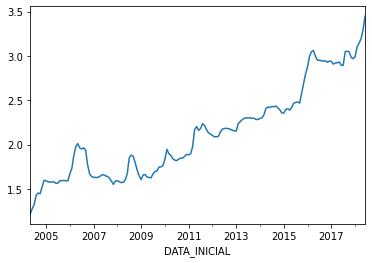

In [14]:
data_pern_train['PRECO_MEDIO_REVENDA'].plot()

<AxesSubplot:xlabel='DATA_INICIAL'>

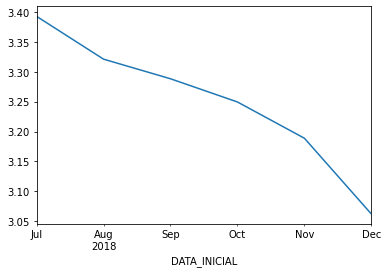

In [15]:
data_pern_validation['PRECO_MEDIO_REVENDA'].plot()

<AxesSubplot:xlabel='DATA_INICIAL'>

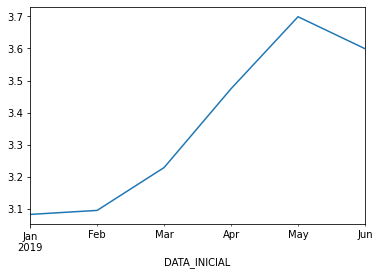

In [16]:
data_pern_test['PRECO_MEDIO_REVENDA'].plot()

Vamos agora realizar uma grid-search para determinar os melhores parâmetros para o algoritmo

In [17]:
y = data_pern_train['PRECO_MEDIO_REVENDA']

In [18]:
def objective(trial):
    p = trial.suggest_int('p', 0, 2)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 2)

    ps = trial.suggest_int('ps', 0, 2)
    ds = trial.suggest_int('ds', 0, 2)
    qs = trial.suggest_int('qs', 0, 0)

    mdl = sm.tsa.statespace.SARIMAX(
        y,
        order=(p, d, q),
        seasonal_order=(ps, ds, qs, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = mdl.fit()

    trial.report(results.aic, 0)

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return results.aic

In [19]:
def print_study_best_trial_params(study):
    t = study.best_trial

    print(f'Melhor valor: {t.value}')

    print(f'Melhores parâmetros:')

    for p, v in t.params.items():
        print(f'{p}: {v}')

In [20]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300)

print_study_best_trial_params(study)

[I 2021-04-16 21:33:51,959] A new study created in memory with name: no-name-d95164b6-860a-490e-8e6a-f9541ec52d14
[I 2021-04-16 21:33:52,843] Trial 0 finished with value: -281.10908413231516 and parameters: {'p': 1, 'd': 0, 'q': 0, 'ps': 2, 'ds': 2, 'qs': 0}. Best is trial 0 with value: -281.10908413231516.
[I 2021-04-16 21:33:53,123] Trial 1 finished with value: -316.28598951061946 and parameters: {'p': 0, 'd': 0, 'q': 2, 'ps': 0, 'ds': 1, 'qs': 0}. Best is trial 1 with value: -316.28598951061946.
/home/co/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
[I 2021-04-16 21:33:54,403] Trial 2 finished with value: -395.8924509611855 and parameters: {'p': 2, 'd': 2, 'q': 0, 'ps': 2, 'ds': 1, 'qs': 0}. Best is trial 2 with value: -395.8924509611855.
[I 2021-04-16 21:33:54,441] Trial 3 finished with value: -536.0278746708

/home/co/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
[I 2021-04-16 21:34:00,124] Trial 38 pruned. 
/home/co/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
[I 2021-04-16 21:34:00,228] Trial 39 pruned. 
[I 2021-04-16 21:34:00,262] Trial 40 pruned. 
[I 2021-04-16 21:34:00,303] Trial 41 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:00,343] Trial 42 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04

[I 2021-04-16 21:34:02,842] Trial 83 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:02,889] Trial 84 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:02,937] Trial 85 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:02,982] Trial 86 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:03,029] Trial 87 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:03,09

[I 2021-04-16 21:34:04,868] Trial 123 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:04,905] Trial 124 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:04,943] Trial 125 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:04,981] Trial 126 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:05,022] Trial 127 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:

[I 2021-04-16 21:34:06,411] Trial 163 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:06,449] Trial 164 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:06,485] Trial 165 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:06,522] Trial 166 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
/home/co/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed 

[I 2021-04-16 21:34:08,073] Trial 203 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:08,119] Trial 204 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:08,168] Trial 205 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:08,219] Trial 206 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:08,259] Trial 207 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:

[I 2021-04-16 21:34:09,873] Trial 244 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:09,913] Trial 245 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:10,015] Trial 246 pruned. 
[I 2021-04-16 21:34:10,055] Trial 247 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:10,102] Trial 248 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:10,141] Trial 249 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with 

[I 2021-04-16 21:34:11,703] Trial 285 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:11,743] Trial 286 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:11,783] Trial 287 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:11,827] Trial 288 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:11,867] Trial 289 finished with value: -576.7262627598973 and parameters: {'p': 1, 'd': 1, 'q': 0, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 18 with value: -576.7262627598973.
[I 2021-04-16 21:34:

Melhor valor: -576.7262627598973
Melhores parâmetros:
p: 1
d: 1
q: 0
ps: 0
ds: 0
qs: 0


Determinados os melhores parâmetros, vamos treinar o nosso modelo e realizar uma previsão

In [21]:
pdq = (2, 0, 1)
pdqs = (0, 0, 0, 12)

mod = sm.tsa.statespace.SARIMAX(
    y,
    order=pdq,
    seasonal_order=pdqs,
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = mod.fit()

In [22]:
mlflow.log_params({ "sarimax_pdq": pdq, "sarimax_pdqs": pdqs })
mlflow.statsmodels.log_model(res, "sarimax")

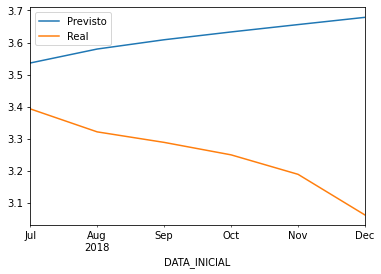

In [23]:
predicted = res.get_prediction(start='2018-07', end='2018-12')
predicted.predicted_mean.plot(label='Previsto')
data_pern_validation['PRECO_MEDIO_REVENDA'].plot(label='Real')
plt.legend()

Repitamos a previsão para o intervalo de tempo de teste

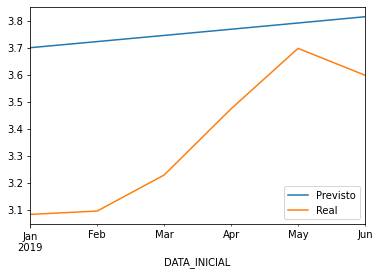

In [24]:
predicted_test = res.get_prediction(start = '2019-01', end='2019-06')
predicted_test.predicted_mean.plot(label='Previsto')
data_pern_test['PRECO_MEDIO_REVENDA'].plot(label='Real')
plt.legend()

MSE (Mean Squared Error):

In [25]:
sarimax_mse = ((predicted_test.predicted_mean - data_pern_test['PRECO_MEDIO_REVENDA']) ** 2).mean()
sarimax_mse

0.19769325390690984

In [26]:
mlflow.log_metric('sarimax_mse', sarimax_mse)

### Prophet

In [27]:
prophet_df = pd.DataFrame()
prophet_df['y'] = data_pern_train['PRECO_MEDIO_REVENDA']
prophet_df['ds'] = data_pern_train.index

<AxesSubplot:xlabel='ds'>

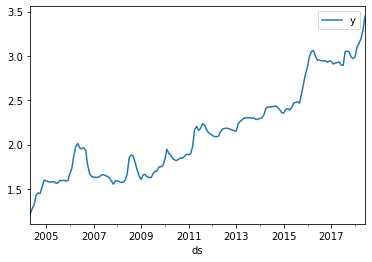

In [28]:
prophet_df.plot(x='ds')

In [29]:
def prophet_objective(trial):
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', .001, .5)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', .01, 10)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', .01, 10)

    prophet = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale
    )

    prophet.fit(prophet_df)

    future_df = prophet.make_future_dataframe(periods=6, freq='m')
    future_pred = prophet.predict(future_df)

    mse = ((future_pred[-6:]['yhat'].reset_index(drop=True) - data_pern_validation['PRECO_MEDIO_REVENDA'].reset_index(drop=True)) ** 2).mean()

    trial.report(mse, 0)

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return mse

In [30]:
prophet_study = optuna.create_study(direction="minimize")
prophet_study.optimize(prophet_objective, n_trials=80)

print_study_best_trial_params(prophet_study)

[I 2021-04-16 21:34:15,539] A new study created in memory with name: no-name-aa8179ec-7a95-41fe-a55f-84d16d2dada0
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-16 21:34:18,034] Trial 0 finished with value: 0.014759923228608246 and parameters: {'changepoint_prior_scale': 0.4681894193944911, 'seasonality_prior_scale': 7.044030418874192, 'holidays_prior_scale': 4.025689129544343}. Best is trial 0 with value: 0.014759923228608246.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-16 21:34:19,564] Trial 1 finished with value: 0.014761978558362693 and parameters: {'changepoint_prior_scale': 0.4503007145571474, 'seasonality_prior_scale': 8.886468179988618, 'hol

[I 2021-04-16 21:34:51,461] Trial 20 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-16 21:34:52,977] Trial 21 finished with value: 0.014544541100335229 and parameters: {'changepoint_prior_scale': 0.484323245778244, 'seasonality_prior_scale': 7.735335474746879, 'holidays_prior_scale': 8.820500612526704}. Best is trial 12 with value: 0.014065714672038973.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-16 21:34:54,651] Trial 22 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021

[I 2021-04-16 21:35:25,534] Trial 42 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-16 21:35:27,056] Trial 43 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-16 21:35:28,510] Trial 44 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-16 21:35:29,987] Trial 45 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overrid

[I 2021-04-16 21:36:04,886] Trial 66 finished with value: 0.014210652041159157 and parameters: {'changepoint_prior_scale': 0.48777070506463993, 'seasonality_prior_scale': 4.425827162707224, 'holidays_prior_scale': 0.011823096779892794}. Best is trial 12 with value: 0.014065714672038973.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-16 21:36:06,815] Trial 67 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-16 21:36:08,606] Trial 68 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I

Melhor valor: 0.014065714672038973
Melhores parâmetros:
changepoint_prior_scale: 0.497115513533589
seasonality_prior_scale: 7.741909301217362
holidays_prior_scale: 9.651243499341527


In [31]:
prophet = Prophet(**prophet_study.best_trial.params)
prophet.fit(prophet_df)
future_df = prophet.make_future_dataframe(periods=6, freq='m')
future_pred = prophet.predict(future_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
last_6_months = future_pred[-6:].reset_index(drop=True)
last_6_months.index = data_pern_test.index

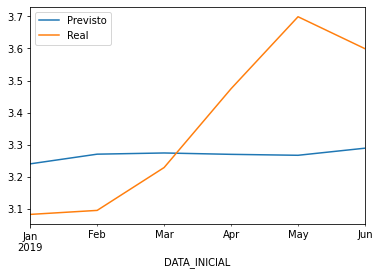

In [33]:
last_6_months['yhat'].plot(label='Previsto')
data_pern_test['PRECO_MEDIO_REVENDA'].plot(label='Real')
plt.legend()

In [34]:
prophet_mse = ((future_pred[-6:]['yhat'].reset_index(drop=True) - data_pern_test['PRECO_MEDIO_REVENDA'].reset_index(drop=True)) ** 2).mean()
prophet_mse

0.06350330080416271

In [35]:
for name, value in prophet_study.best_trial.params.items():
    mlflow.log_param(f'fbprophet_{name}', value)
mlflow.sklearn.log_model(prophet, 'prophet')
mlflow.log_metric('prophet_mse', prophet_mse)

**Auto Regression**

In [36]:
ar_y = data_pern_train['PRECO_MEDIO_REVENDA']

In [37]:
from statsmodels.tsa.ar_model import AutoReg

def ar_objective(trial):
    mdl = AutoReg(ar_y, lags=trial.suggest_int('lags', 0, 6))
    
    res = mdl.fit()
    
    aic = res.aic
    
    trial.report(aic, 0)
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
        
    return aic

In [38]:
ar_study = optuna.create_study(direction="minimize")
ar_study.optimize(ar_objective, n_trials=10)

print_study_best_trial_params(ar_study)

[I 2021-04-16 21:36:29,856] A new study created in memory with name: no-name-90719456-30b3-4b7e-9494-1186f6da7775
[I 2021-04-16 21:36:29,876] Trial 0 finished with value: -6.278137971701282 and parameters: {'lags': 3}. Best is trial 0 with value: -6.278137971701282.
[I 2021-04-16 21:36:29,889] Trial 1 finished with value: -6.278137971701282 and parameters: {'lags': 3}. Best is trial 0 with value: -6.278137971701282.
[I 2021-04-16 21:36:29,897] Trial 2 finished with value: -6.272175930792029 and parameters: {'lags': 5}. Best is trial 0 with value: -6.278137971701282.
[I 2021-04-16 21:36:29,902] Trial 3 finished with value: -6.278137971701282 and parameters: {'lags': 3}. Best is trial 0 with value: -6.278137971701282.
[I 2021-04-16 21:36:29,908] Trial 4 finished with value: -6.282334891672952 and parameters: {'lags': 4}. Best is trial 4 with value: -6.282334891672952.
[I 2021-04-16 21:36:29,913] Trial 5 finished with value: -6.278137971701282 and parameters: {'lags': 3}. Best is trial 4 

Melhor valor: -6.282334891672952
Melhores parâmetros:
lags: 4


In [39]:
ar_mdl = AutoReg(ar_y, **ar_study.best_trial.params)
ar_res = ar_mdl.fit()

In [40]:
mlflow.log_param('ar_lags', ar_study.best_trial.params['lags'])
mlflow.statsmodels.log_model(ar_res, 'autoregression')

Os parâmetros de previsão para o modelo de autoregressão são os índices de início e fim da previsão. Como desejamos prever 6 meses, devemos fornecer o índice do último item mais um, que é o mesmo que o tamanho de ar_y, e o índice do sexto mês a partir do fim

In [41]:
prediction = ar_res.predict(start=len(ar_y), end=len(ar_y) + 5)
prediction

2018-07-31    3.533821
2018-08-31    3.571089
2018-09-30    3.592936
2018-10-31    3.613910
2018-11-30    3.636479
2018-12-31    3.659985
Freq: M, dtype: float64

In [42]:
prediction.index = data_pern_test.index

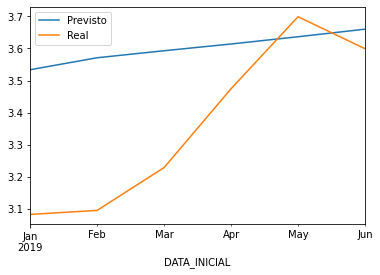

In [43]:
prediction.plot(label='Previsto')
data_pern_test['PRECO_MEDIO_REVENDA'].plot(label='Real')
plt.legend()

In [44]:
ar_mse = ((data_pern_test['PRECO_MEDIO_REVENDA'] - prediction) ** 2).mean()
ar_mse

0.09793155747593428

In [45]:
mlflow.log_metric('ar_mse', ar_mse)

### Holt Winter's Exponential Smoothing

In [46]:
hwes_y = data_pern_train['PRECO_MEDIO_REVENDA']

In [47]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [48]:
def hwes_objective(trial):
    component_type = {"additive", "multiplicative", None}
    
    mdl = ExponentialSmoothing(
        hwes_y,
        seasonal=trial.suggest_categorical("seasonal", component_type),
        trend=trial.suggest_categorical("trend", component_type)
    )
    
    res = mdl.fit()
    
    aic = res.aic
    
    trial.report(aic, 0)
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
        
    return aic

In [49]:
hwes_study = optuna.create_study(direction="minimize")
hwes_study.optimize(hwes_objective, n_trials=9)

print_study_best_trial_params(hwes_study)

[I 2021-04-16 21:36:31,638] A new study created in memory with name: no-name-7966b4ad-6e7a-4e06-ae1b-12a75d612071
/home/co/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
[I 2021-04-16 21:36:31,742] Trial 0 finished with value: -891.9966647087347 and parameters: {'seasonal': 'multiplicative', 'trend': 'additive'}. Best is trial 0 with value: -891.9966647087347.
[I 2021-04-16 21:36:31,746] Trial 1 finished with value: -1009.6077505392568 and parameters: {'seasonal': None, 'trend': None}. Best is trial 1 with value: -1009.6077505392568.
/home/co/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
[I 2021-04-16 21:36:31,813] Trial 2 finished with value: -930.4298989582551 and 

Melhor valor: -1009.6077505392568
Melhores parâmetros:
seasonal: None
trend: None


In [50]:
hwes_model = ExponentialSmoothing(hwes_y, **hwes_study.best_trial.params)
hwes_res = hwes_model.fit()

In [51]:
mlflow.log_param('hwes_trend', hwes_study.best_trial.params['trend'])
mlflow.statsmodels.log_model(hwes_res, 'hwes')

In [52]:
prediction = hwes_res.predict(start=len(hwes_y), end=(len(hwes_y) + 5))
prediction.index = data_pern_test.index

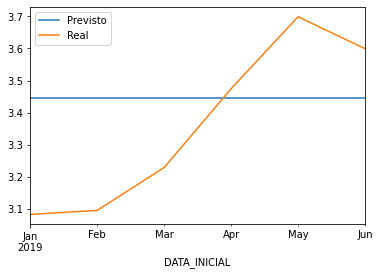

In [53]:
prediction.plot(label='Previsto')
data_pern_test['PRECO_MEDIO_REVENDA'].plot(label='Real')
plt.legend()

In [54]:
hwes_mse = ((data_pern_test['PRECO_MEDIO_REVENDA'] - prediction) ** 2).mean()
hwes_mse

0.06496023291666665

In [55]:
mlflow.log_metric('hwes_mse', hwes_mse)

In [56]:
print(
    f'MSE SARIMAX: {sarimax_mse}\n'
    f'MSE Prophet: {prophet_mse}\n'
    f'MSE AutoRegression: {ar_mse}\n'
    f"MSE Holt Winter's Exponential Smoothing: {hwes_mse}\n"
)

MSE SARIMAX: 0.19769325390690984
MSE Prophet: 0.06350330080416271
MSE AutoRegression: 0.09793155747593428
MSE Holt Winter's Exponential Smoothing: 0.06496023291666665

